### Prediction after reopen

In [1]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import mlflow
from logging import getLogger
import logging 
import torch
logger = getLogger(__name__)

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import (
    tokenize
)

In [3]:
DATA_PATH = '../data/data_multiclass_with_none.csv'
MODEL_PATH_TOKENIZER = "distilbert-base-uncased"

In [4]:
df = pd.read_csv(DATA_PATH)

In [5]:
#load model
path_pt = "../models/distilbert_multiclass_with_none/pytorch_model"
model = mlflow.pytorch.load_model(path_pt)

In [6]:
def get_encode_tokenize_data(problem, data_path, model_path_tokenizer):
    logger = getLogger(__name__)

    logger.info("Loading data...")
    df = pd.read_csv(data_path)
    
    # Determine target column based on problem type
    target_column = "two_class_target" if problem == "binary" else "logical_fallacies"
    y = df[target_column]
    
    X = df[["dataset", "text"]]
    logger.info("Train test split, test-size 0.3")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.30, random_state=42
    )

    logging.info("Create encoded dataframes")
    encoded_train_dataset = X_train.copy()
    encoded_test_dataset = X_test.copy()
    
    encoded_train_dataset[target_column] = y_train
    encoded_test_dataset[target_column] = y_test
    
    X_train = X_train["text"]
    X_test = X_test["text"]

    logging.info("Encode the label column")
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    logging.info("Tokenize")
    train_encodings = tokenize(X_train.to_list(), model_path_tokenizer)
    test_encodings = tokenize(X_test.to_list(), model_path_tokenizer)

    return train_encodings, test_encodings, y_train, y_test, le

In [7]:
#change problem accordingly
train_encodings, test_encodings, y_train, y_test, le = get_encode_tokenize_data("mutliclass", DATA_PATH, MODEL_PATH_TOKENIZER)

In [8]:
def predict(model, encodings, batch_size=8):
    # Set the model to evaluation mode
    model.eval()
    
    # Use GPU
    device = torch.device("mps")
    model.to(device)
    
    # Perform inference
    probabilities = []
    for i in range(0, len(encodings["input_ids"]), batch_size):
        with torch.no_grad():
            batch = {
                key: val[i:i+batch_size].to(device) 
                for key, val in encodings.items()
            }
            outputs = model(**batch)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            probabilities.extend(probs)
            
        # Clear GPU memory after each batch
        torch.mps.empty_cache()
    
    return np.array(probabilities)

In [9]:
base_probs = predict(model, test_encodings, batch_size=2)

In [10]:
def get_first_prediction(proba):
    preds = np.argmax(proba, axis=1)
    probas = proba[np.arange(len(preds)), preds]
    return preds, probas

In [11]:
predicted_labels, predicted_proba = get_first_prediction(base_probs)

In [12]:
def get_metrics(y_true, y_pred):
    logger.info('classification_report')
    classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))

    logger.info('confusion_matrix')
    cm = (confusion_matrix(y_true, y_pred))

    labels = le.classes_

    logger.info('heatmap')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix Heatmap")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return classification_report_dict

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       162
           1       0.73      0.73      0.73       143
           2       0.66      0.70      0.68       174
           3       0.81      0.69      0.75       163
           4       0.54      0.64      0.59       160
           5       0.72      0.88      0.79       158

    accuracy                           0.70       960
   macro avg       0.71      0.70      0.70       960
weighted avg       0.71      0.70      0.70       960



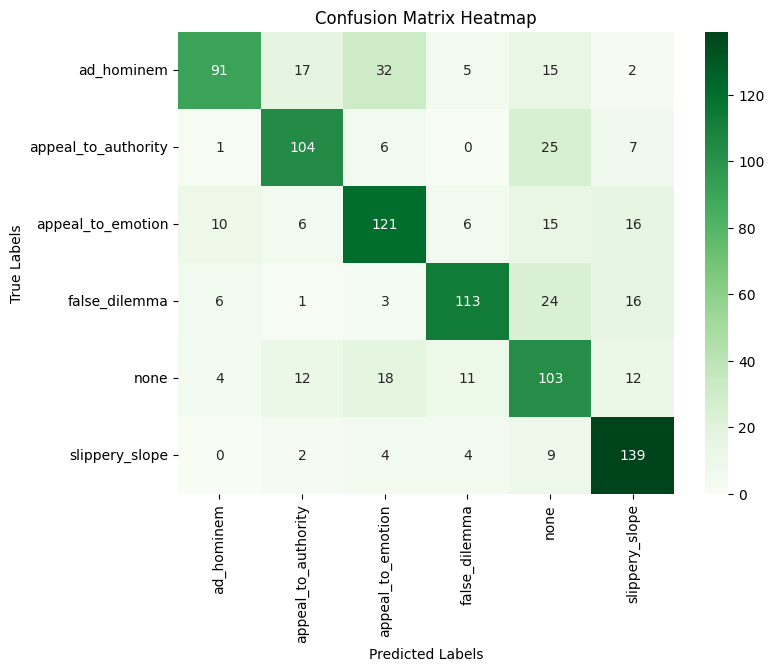

{'0': {'precision': 0.8125,
  'recall': 0.5617283950617284,
  'f1-score': 0.6642335766423357,
  'support': 162.0},
 '1': {'precision': 0.7323943661971831,
  'recall': 0.7272727272727273,
  'f1-score': 0.7298245614035088,
  'support': 143.0},
 '2': {'precision': 0.657608695652174,
  'recall': 0.6954022988505747,
  'f1-score': 0.6759776536312849,
  'support': 174.0},
 '3': {'precision': 0.8129496402877698,
  'recall': 0.6932515337423313,
  'f1-score': 0.7483443708609272,
  'support': 163.0},
 '4': {'precision': 0.5392670157068062,
  'recall': 0.64375,
  'f1-score': 0.5868945868945868,
  'support': 160.0},
 '5': {'precision': 0.7239583333333334,
  'recall': 0.879746835443038,
  'f1-score': 0.7942857142857143,
  'support': 158.0},
 'accuracy': 0.6989583333333333,
 'macro avg': {'precision': 0.7131130085295444,
  'recall': 0.7001919650617333,
  'f1-score': 0.6999267439530596,
  'support': 960.0},
 'weighted avg': {'precision': 0.7124585812045183,
  'recall': 0.6989583333333333,
  'f1-score'

In [13]:
get_metrics(y_test, predicted_labels)